In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
!ollama list

NAME                       ID              SIZE      MODIFIED     
nomic-embed-text:latest    0a109f422b47    274 MB    2 weeks ago     
phi3:latest                4f2222927938    2.2 GB    2 months ago    
gemma2:2b                  8ccf136fdd52    1.6 GB    2 months ago    
llama3.2:latest            a80c4f17acd5    2.0 GB    2 months ago    
deepseek-r1:8b             28f8fd6cdc67    4.9 GB    2 months ago    


In [3]:
EMBEDDING_MODEL = "nomic-embed-text"
LLM_MODEL = "llama3.2"

In [4]:
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings

llm = ChatOllama(model=LLM_MODEL, temperature=0)

embedding = OllamaEmbeddings(model=EMBEDDING_MODEL)

In [ ]:
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

In [31]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=300, chunk_overlap=50)

splits = text_splitter.split_documents(blog_docs)

In [5]:
import chromadb

chroma_client = chromadb.Client()
collections = chroma_client.list_collections()

collections

# chroma_client = delete_collection("langchain")
# chroma_client.list_collections()

[]

Uncomment and run this first if it's your first time indexing these documents

In [6]:
# from langchain_community.vectorstores import Chroma

# # Embed
# vectorstore = Chroma.from_documents(
#     persist_directory="./chroma_db",
#     documents=splits,
#     embedding=OllamaEmbeddings(
#         model=EMBEDDING_MODEL
#     )
# )

# retriever = vectorstore.as_retriever()

In [7]:
from langchain_chroma import Chroma

# Embed
vectorstore = Chroma(
    persist_directory="./chroma_db",
    embedding_function=embedding
)

retriever = vectorstore.as_retriever()

# Query Translation

Distance-based vector database retrieval embeds queries in high-dimensional space and finds similar embedded documents based on a distance metric.

But, retrieval may produce different results with subtle changes in query wording, or if the embeddings do not capture the semantics of the data well. Prompt engineering / tuning is sometimes done to manually address these problems, but can be tedious.

## Multi Query Retrieval

Using an LLM to generate multiple queries from different perspectives for a given user input query.

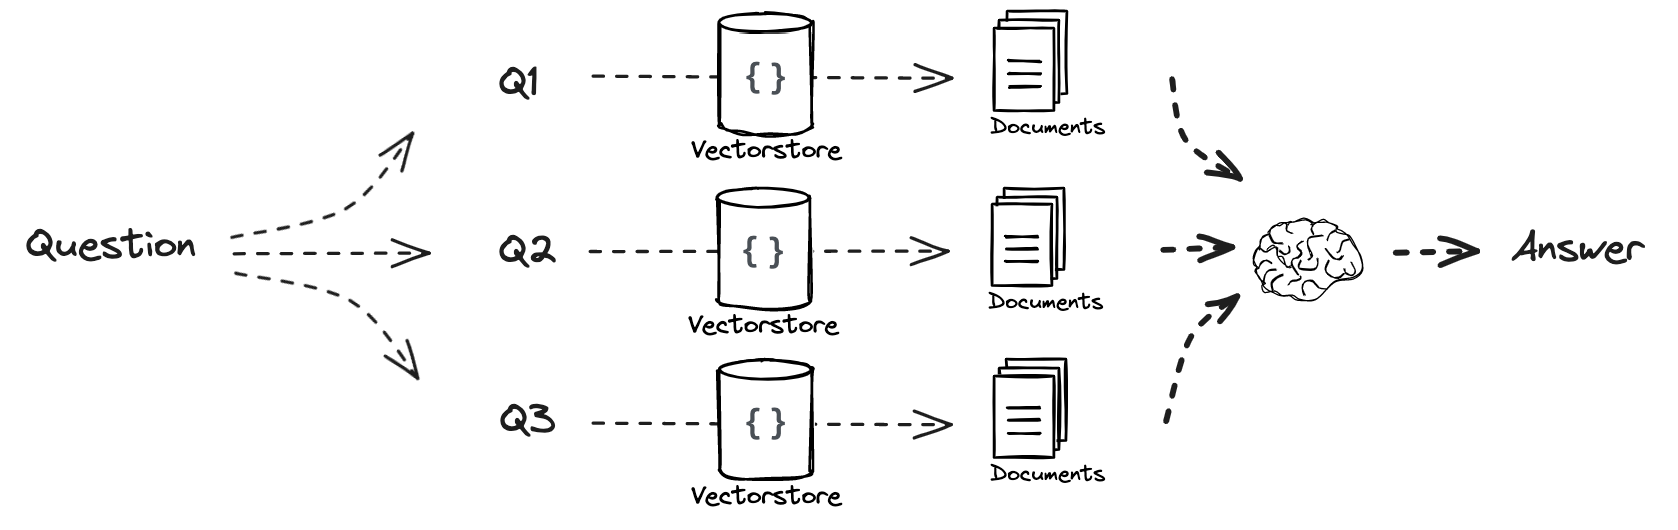

### Prompt

In [46]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate exactly five 
different versions of the given user question to retrieve relevant documents from a vector 
database. Provide these alternative questions as a plain list without any introductory text 
or numbering. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

In [47]:
from langchain_core.output_parsers import StrOutputParser

generate_queries = (
    prompt_perspectives 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [48]:
question = "What is task decomposition for LLM agents?"
docs = generate_queries.invoke({"question":question})
len(docs)

5

In [49]:
docs

['What is the concept of task decomposition in Large Language Model (LLM) agents?',
 'How does task decomposition work for LLM agents?',
 'What are the benefits of using task decomposition with LLM agents?',
 'Can you explain the process of task decomposition for LLM agents?',
 'How does task decomposition improve the performance of LLM agents?']

In [50]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

5

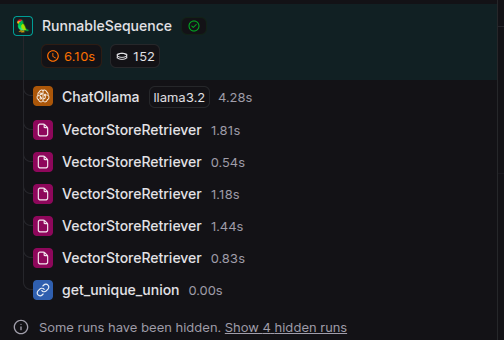

In [51]:
from operator import itemgetter
from langchain_ollama import ChatOllama
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'According to the text, task decomposition for LLM (Large Language Model) agents involves breaking down large tasks into smaller, manageable subgoals. This can be done in three ways:\n\n1. Using simple prompting, such as "Steps for XYZ. 1.", or "What are the subgoals for achieving XYZ?"\n2. Using task-specific instructions, such as "Write a story outline." for writing a novel\n3. With human inputs.\n\nTask decomposition is used to enable efficient handling of complex tasks and allows the LLM agent to plan ahead and make progress towards its goals.'

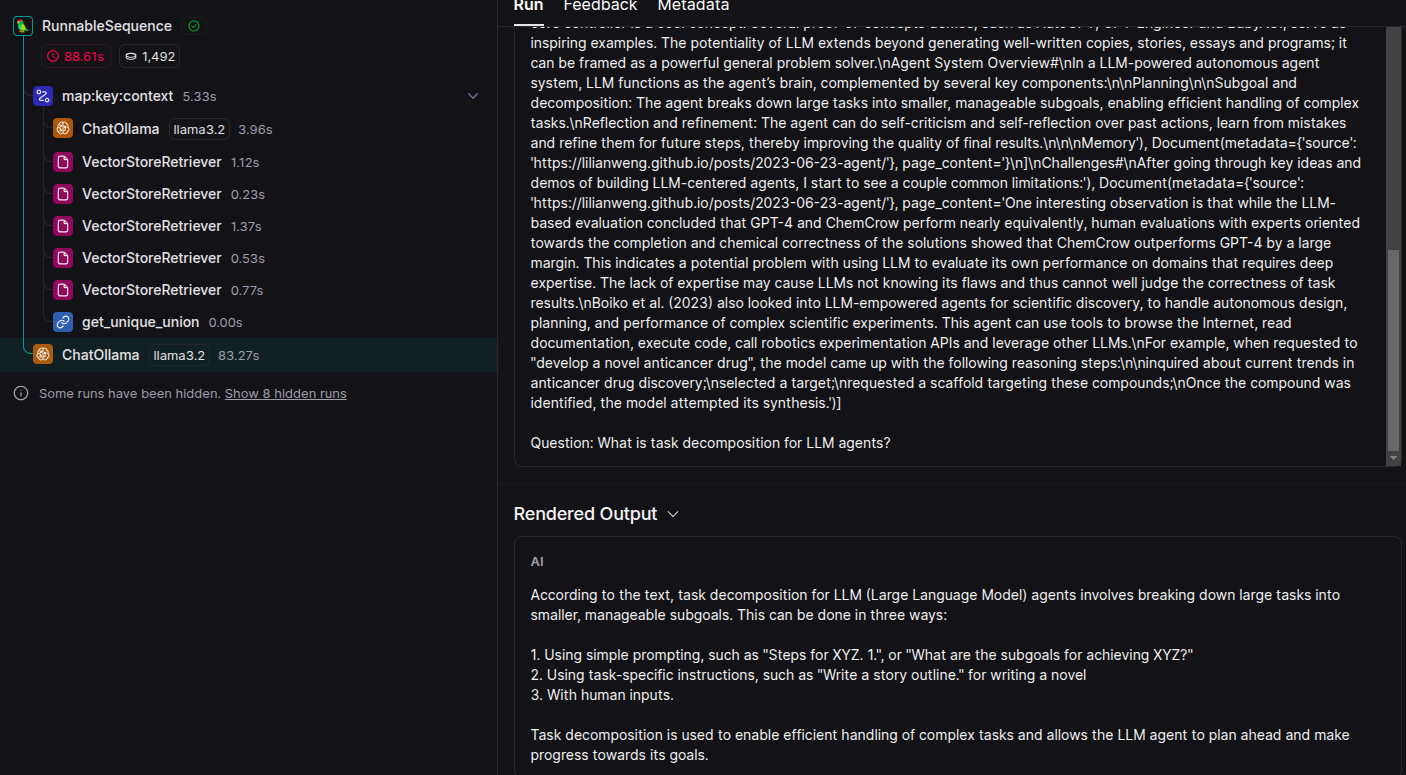

## Rag Fusion

Using an LLM to generate multiple queries based on a signle input query, then using reciprocal rank fusion that takes mutiple lists of ranked documents and aggregates them to a final output ranking.

### Prompt

In [8]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Provide these alternative questions as a plain list without any introductory text 
or numbering. Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [9]:
from langchain_core.output_parsers import StrOutputParser

generate_queries = (
    prompt_rag_fusion 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [10]:
question = "What is task decomposition for LLM agents?"
docs = generate_queries.invoke({"question":question})
len(docs)

4

In [11]:
docs

['What is the purpose of task decomposition in large language model (LLM) agents?',
 'How does task decomposition improve the performance of LLM agents?',
 'What are the benefits of using task decomposition for LLM agents?',
 'Can task decomposition be used to address common challenges in LLM agent development?']

In [12]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

In [13]:
# Retrieve
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

/tmp/ipykernel_66569/239430494.py:26: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  (loads(doc), score)


5

In [14]:
from operator import itemgetter

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM (Large Language Model) agents involves breaking down large tasks into smaller, manageable subgoals. This allows the agent to efficiently handle complex tasks.\n\nThere are three ways to perform task decomposition:\n\n1. Using simple prompting with instructions like "Steps for XYZ. 1.", "What are the subgoals for achieving XYZ?"\n2. Using task-specific instructions, such as "Write a story outline." for writing a novel\n3. With human inputs\n\nTask decomposition enables efficient handling of complex tasks and is an important component of LLM-powered autonomous agent systems.'

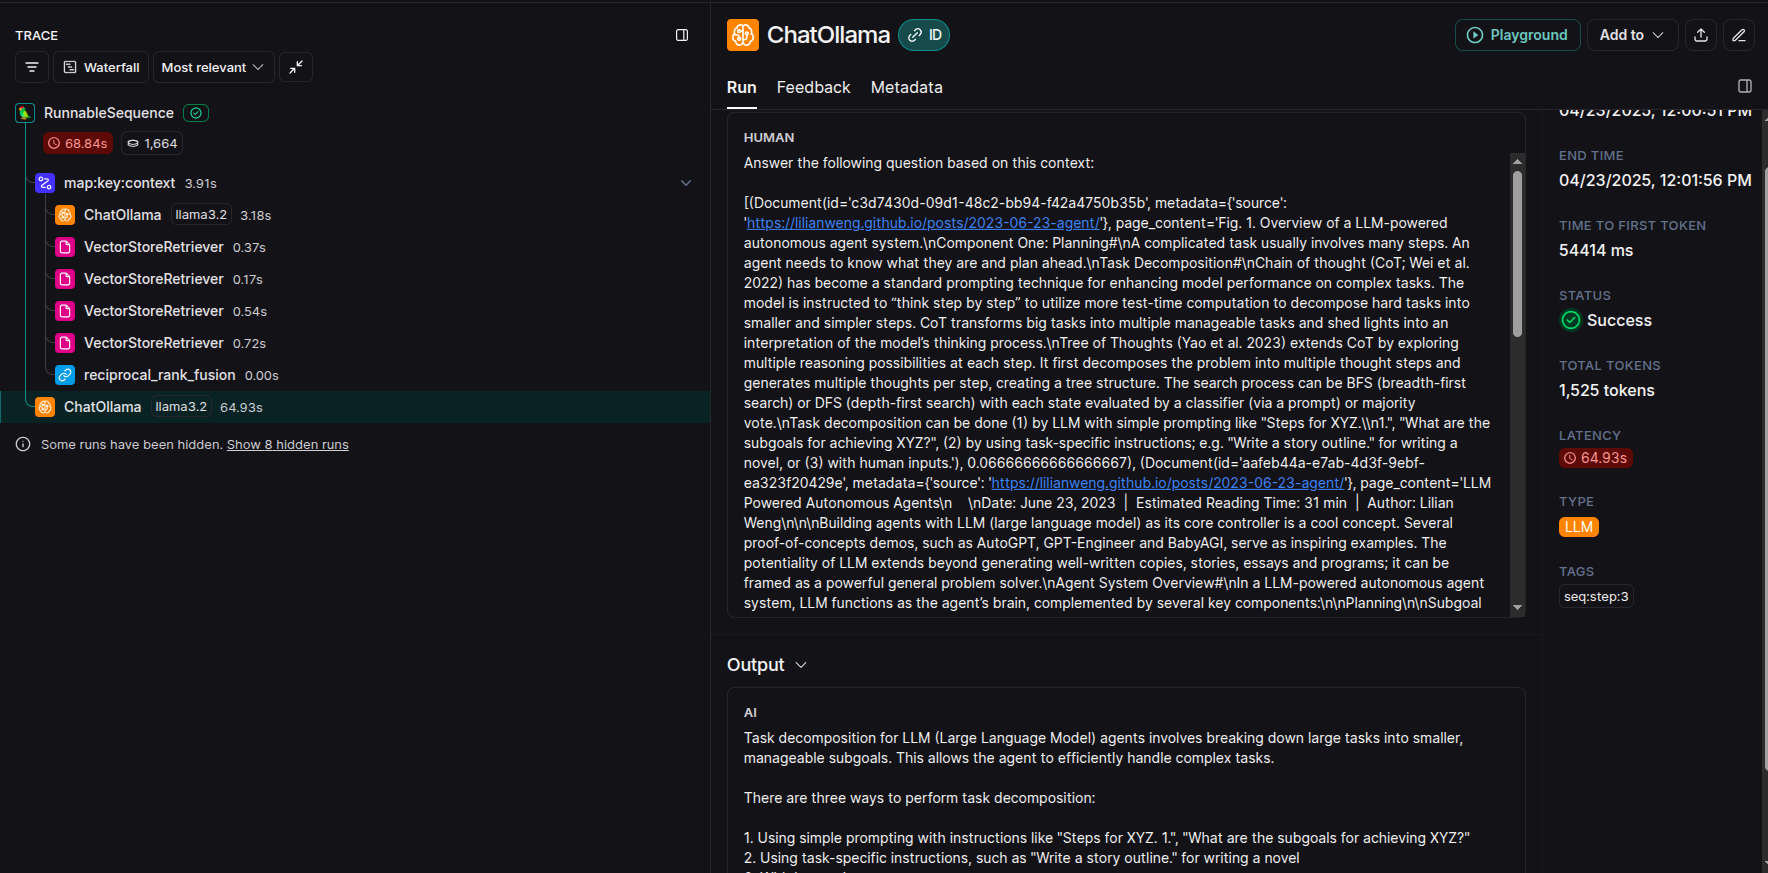

## Decomposition

Using an LLM to generate multiple sub-questions related to a single input question, then dynamically retrieve to help solve the sub-problems.

### Prompt

In [19]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Provide these sub-questions as a plain list without any introductory text 
or numbering.
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [37]:
from langchain_core.output_parsers import StrOutputParser

generate_queries_decomposition = (
    prompt_decomposition 
    | llm
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [38]:
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})
questions = [x for x in questions if x != '']
len(questions)

3

In [39]:
 questions

['What are the key components of a large language model (LLM) used in autonomous decision-making?',
 'What role do natural language processing (NLP) and machine learning algorithms play in LLM-powered autonomous agents?',
 'How do LLMs integrate with other AI technologies, such as computer vision or reinforcement learning, to create a comprehensive autonomous system?']

## 1. Answer recursively
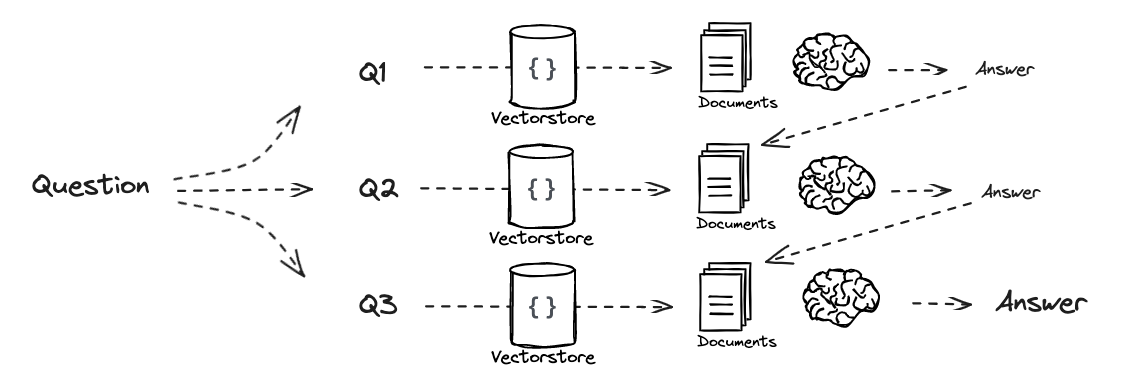

In [31]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [32]:
from operator import itemgetter

# Retrieve

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()
    
q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [33]:
answer

'Based on the provided context and background question + answer pairs, large language models (LLMs) can integrate with other AI technologies, such as computer vision or reinforcement learning, to create a comprehensive autonomous system in several ways:\n\n1. **Planning**: LLMs can be used for planning by breaking down complex tasks into smaller, manageable subgoals through techniques like subgoal and decomposition, reflection and refinement, task decomposition, and tree of thoughts. This allows the agent to plan ahead and make decisions autonomously.\n2. **Memory**: LLMs have limited context capacity, but mechanisms like vector stores and retrieval can provide access to a larger knowledge pool, enabling the agent to learn from past experiences and improve its decision-making.\n3. **Computer Vision**: Computer vision can be integrated with LLMs to enable the agent to understand and process visual inputs, such as images or videos. This can be done through techniques like object detectio

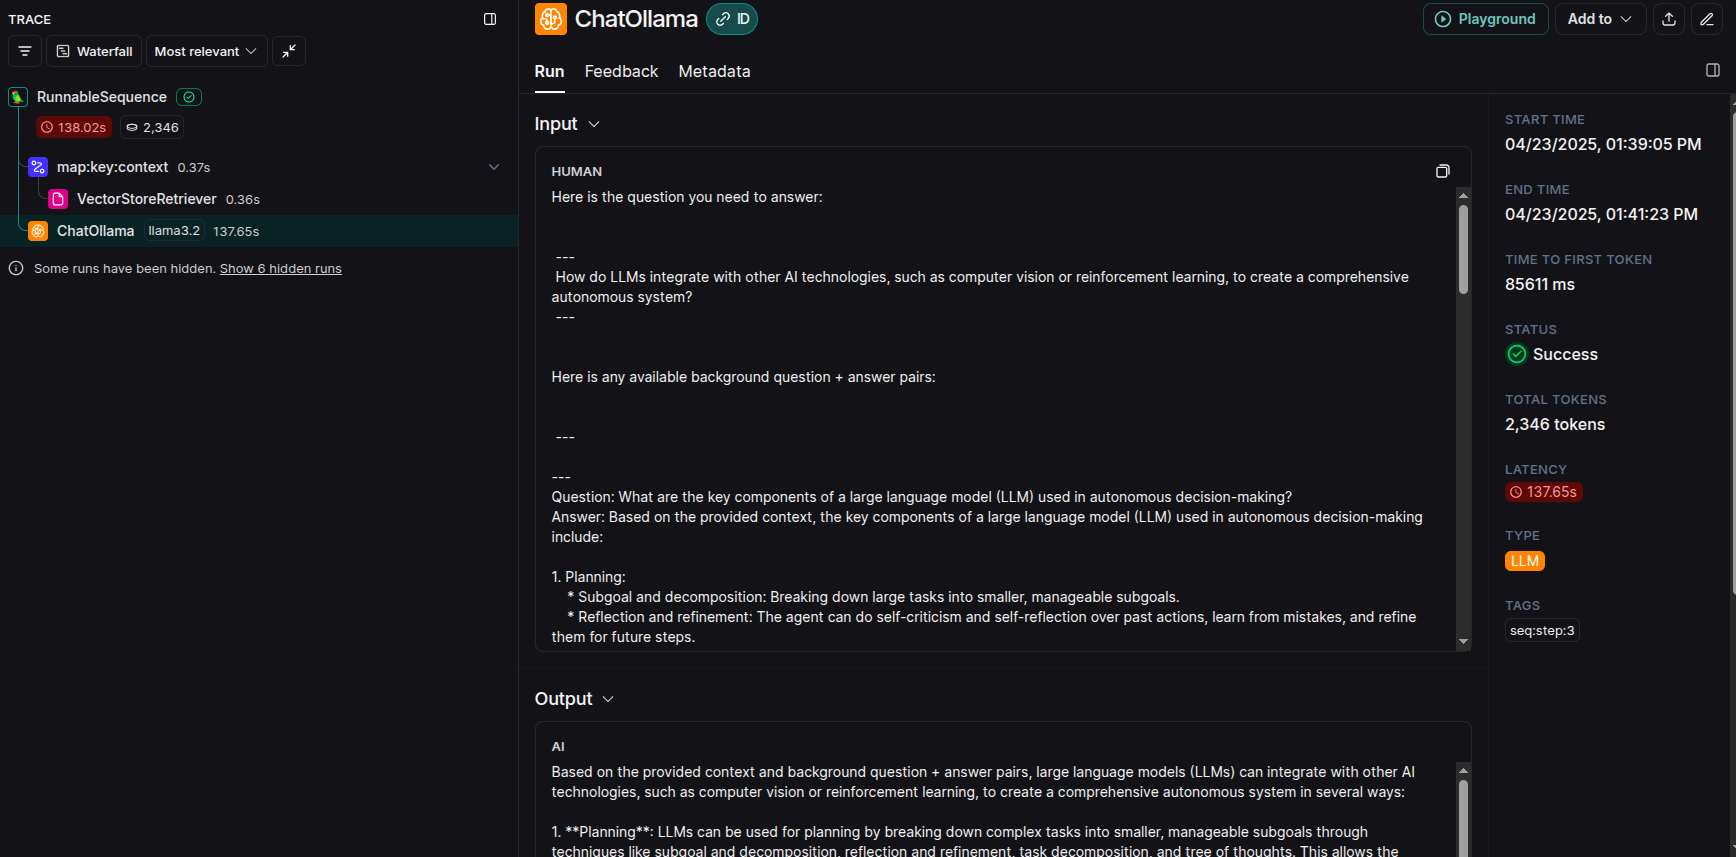

## 2. Answer individually
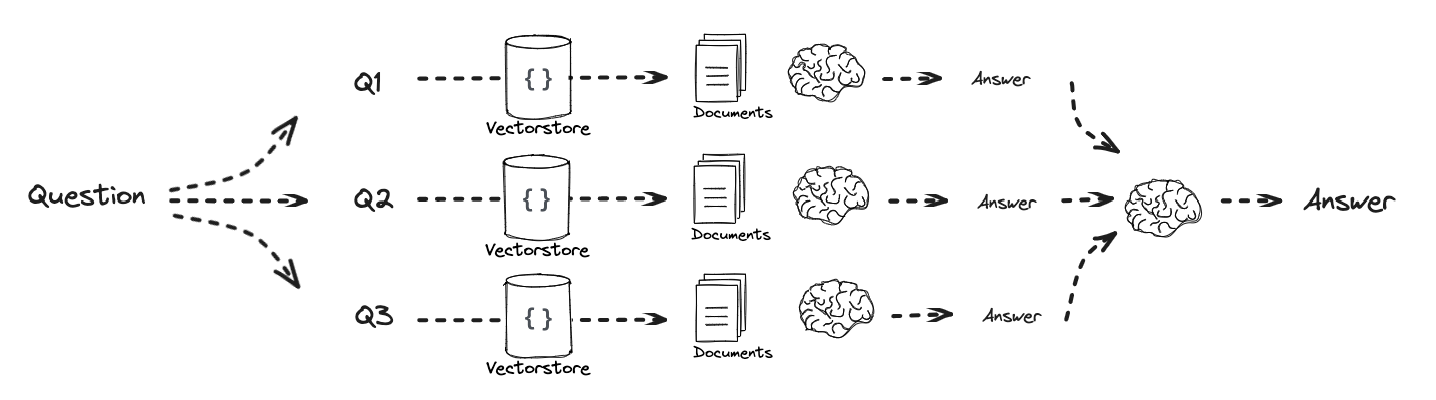

In [40]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag, sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    sub_questions = [x for x in sub_questions if x != '']
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

/tmp/ipykernel_66569/3627791819.py:20: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(sub_question)


In [42]:
answers, questions

(['The key components of a large language model (LLM) used in autonomous decision-making are planning, reflection and refinement, and memory. Planning involves breaking down complex tasks into smaller subgoals, while reflection and refinement enable the agent to learn from mistakes and improve its performance over time. Memory plays a crucial role in storing historical information and providing access to a larger knowledge pool.',
  'NLP and machine learning algorithms play a crucial role in LLM-powered autonomous agents by enabling the agent to break down complex tasks into smaller subgoals, reflect on past actions, learn from mistakes, and refine its plans. NLP is used for task decomposition, planning, and self-reflection, while machine learning algorithms are employed for self-criticism, error detection, and adaptation to new situations. These algorithms help the agent to improve its performance over time through trial and error.',
  "LLMs integrate with other AI technologies throug

In [41]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

In [43]:
# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

In [44]:
final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

"The main components of an LLM-powered autonomous agent system include planning, reflection and refinement, memory, natural language processing (NLP), machine learning algorithms, computer vision, and reinforcement learning. Planning involves breaking down complex tasks into smaller subgoals, while reflection and refinement enable the agent to learn from mistakes and improve its performance over time. Memory plays a crucial role in storing historical information and providing access to a larger knowledge pool.\n\nNLP is used for task decomposition, planning, and self-reflection, allowing the agent to break down complex tasks into smaller subgoals and reflect on past actions. Machine learning algorithms are employed for self-criticism, error detection, and adaptation to new situations, helping the agent to improve its performance over time through trial and error.\n\nComputer vision is integrated with LLMs to provide a comprehensive understanding of the environment, while reinforcement 

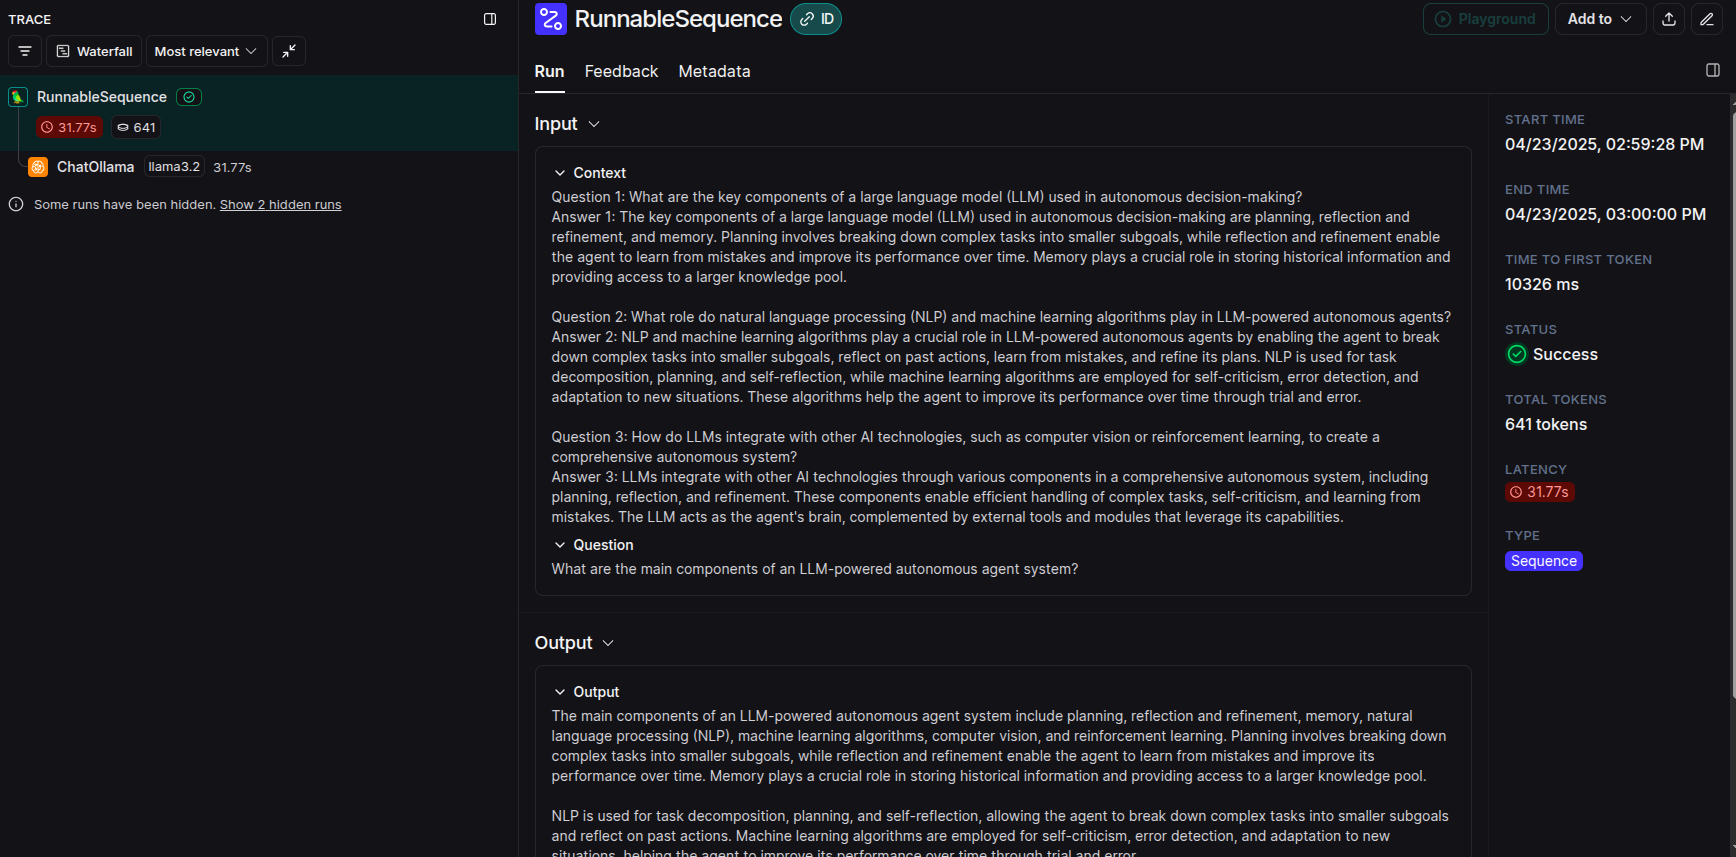